In [23]:
import numpy as np
import idtxl as id
import causalnex as cn
from causalnex.structure.notears import from_pandas_lasso, from_pandas
from causalnex.structure import StructureModel
from causalnex.network import BayesianNetwork
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from idtxl.estimators_pid import TartuPID, SydneyPID
from idtxl.multivariate_pid import MultivariatePID
from idtxl.multivariate_mi import MultivariateMI
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from causalnex.inference import InferenceEngine
from idtxl.data import Data
from idtxl.estimators_jidt import (JidtDiscreteAIS, JidtDiscreteCMI,
                                   JidtDiscreteMI, JidtDiscreteTE,
                                   JidtKraskovAIS, JidtKraskovCMI,
                                   JidtKraskovMI, JidtKraskovTE,
                                   JidtGaussianAIS, JidtGaussianCMI,
                                   JidtGaussianMI, JidtGaussianTE)
import warnings
import jpype as jp
import pandas as pd
from tqdm import tqdm
from tqdm.contrib.itertools import product
import itertools
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")  # silence warnings


In [2]:
## Create Bayesian Net Structure

colnames=["age","workclass","fnlwgt","education","educationnum","maritalstatus","occupation","relationship","race","sex","capitalgain","capitalloss","hoursperweek","nativecountry","income"]
data = pd.read_csv('adult/adult.data', index_col=False, names=colnames, delimiter=',')
data = data.drop('fnlwgt',axis=1)
data = data.drop('capitalgain',axis=1)
data = data.drop('capitalloss',axis=1)
data = data.drop('educationnum',axis=1)
data = data.drop('age',axis=1)
data = data.drop('sex',axis=1)
data = data.drop('nativecountry',axis=1)
data = data.drop('race',axis=1)
#data = data.drop('workclass',axis=1)
#data = data.drop('relationship',axis=1)
#data = data.drop('hoursperweek',axis=1)
data['hoursperweek'] = np.round(data['hoursperweek'],decimals=-1)
#data['age'] = np.round(data['age'],decimals=-1)

#data[data['race'] == ' Amer-Indian-Eskimo']['race'] = ' Other'
#data[data['race'] == ' Asian-Pac-Islander']['race'] = ' Other'


struct_data = data.copy()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)

le = LabelEncoder()

for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

sm = StructureModel()
sm.add_edges_from([
    #('nativecountry', 'maritalstatus'),
    #('nativecountry', 'workclass'),
    #('nativecountry', 'relationship'),
    #('nativecountry', 'education'),
    #('nativecountry', 'hoursperweek'),
    #('nativecountry', 'income'),
    #('age', 'maritalstatus'),
    #('age', 'workclass'),
    #('age', 'relationship'),
    #('age', 'education'),
    #('age', 'hoursperweek'),
    #('age', 'occupation'),
    #('age', 'income'),
    #('sex', 'relationship'),
    #('sex', 'maritalstatus'),
    #('sex', 'education'),
    #('sex', 'hoursperweek'),
    #('sex', 'occupation'),
    #('sex', 'income'),
    #('race', 'maritalstatus'),
    #('race', 'education'),
    #('race', 'hoursperweek'),
    #('race', 'occupation'),
    #('race', 'income'),
    ('maritalstatus', 'income'),
    ('maritalstatus', 'workclass'),
    ('maritalstatus', 'relationship'),
    ('maritalstatus', 'education'),
    ('maritalstatus', 'hoursperweek'),
    ('maritalstatus', 'occupation'),
    ('education', 'workclass'),
    ('education', 'relationship'),
    ('education', 'hoursperweek'),
    ('education', 'income'),
    ('education', 'occupation'),
    ('workclass', 'income'),
    ('relationship', 'income'),
    ('hoursperweek', 'income'),
    ('occupation', 'income')
])

viz = plot_structure(
    sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)

viz.toggle_physics(False)
viz.show("adult_bayesian_net.html")

adult_bayesian_net.html


In [3]:
## Fit Conditional Probability Distributions and Query Marginals of Income
bn=BayesianNetwork(sm)
train,test = train_test_split(data,train_size=0.9,test_size=0.1,random_state=7)
bn = bn.fit_node_states(data)
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")
#bn.cpds['income']
pred=bn.predict(test,'income')
ie = InferenceEngine(bn)
marginals = ie.query()
print("marginal Income", ie.query()["income"])

marginal Income {' <=50K': 0.6256285843261649, ' >50K': 0.37437141567191795}


In [4]:

## Measure of effect of Atomic Interventions
all_interventions=[]
for feature in tqdm(data.columns[:-1]):
    
    feat_dict={}
    events=np.unique(data[feature])

    for idx in range(len(events)):
        prob=np.zeros(len(np.unique(data[feature])))
        prob[idx]=1.0
        intervention=dict(zip(np.unique(data[feature]), prob))
        ie.do_intervention(feature,intervention)
        feat_dict[events[idx]] = ie.query()["income"][' >50K']
        ie.reset_do(feature)

    all_interventions.append(feat_dict)

events=[]
income_prob=[]
for feature in all_interventions:
    events.append(max(feature, key=feature.get))
    income_prob.append(feature[max(feature, key=feature.get)])
print(events)
print(income_prob)

100%|██████████| 6/6 [1:52:15<00:00, 1122.62s/it]


In [30]:
## Measure of effect of hours-per-week and education combined intervention
hours=np.unique(data['hoursperweek'])
edu=np.unique(data['education'])
intervention_sets=[]
for comb in product(range(len(hours)),range(len(edu))):
    hours_prob=np.zeros(len(hours))
    edu_prob=np.zeros(len(edu))
    hours_prob[comb[0]]=1.0
    edu_prob[comb[1]]=1.0
    hours_intervention=dict(zip(hours,hours_prob))
    edu_intervention=dict(zip(edu,edu_prob))
    ie.do_intervention('hoursperweek',hours_intervention)
    ie.do_intervention('education',edu_intervention)
    intervention_sets.append([hours[comb[0]],edu[comb[1]],ie.query()["income"][' >50K']])
    ie.reset_do('hoursperweek')
    ie.reset_do('education')

best_int=0
best_int_idx=0
for i in range(len(intervention_sets)):
    if intervention_sets[i][2] > best_int:
        best_int = intervention_sets[i][2]
        best_int_idx = i
print(intervention_sets[best_int_idx])

100%|██████████| 176/176 [5:15:44<00:00, 107.64s/it]  


In [54]:
## Measure of effect of workclass and education combined intervention
works=np.unique(data['workclass'])
edu=np.unique(data['education'])
intervention_sets=[]
for comb in product(range(len(works)),range(len(edu))):
    works_prob=np.zeros(len(works))
    edu_prob=np.zeros(len(edu))
    works_prob[comb[0]]=1.0
    edu_prob[comb[1]]=1.0
    works_intervention=dict(zip(works,works_prob))
    edu_intervention=dict(zip(edu,edu_prob))
    ie.do_intervention('workclass',works_intervention)
    ie.do_intervention('education',edu_intervention)
    intervention_sets.append([works[comb[0]],edu[comb[1]],ie.query()["income"][' >50K']])
    ie.reset_do('workclass')
    ie.reset_do('education')

best_int=0
best_int_idx=0
for i in range(len(intervention_sets)):
    if intervention_sets[i][2] > best_int:
        best_int = intervention_sets[i][2]
        best_int_idx = i
print(intervention_sets[best_int_idx])

100%|██████████| 144/144 [4:06:49<00:00, 102.84s/it]  


In [43]:
## BROJA PID

# a) Generate test data
colnames=["age","workclass","fnlwgt","education","education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","income"]
data = pd.read_csv('adult/adult.data', index_col=False, names=colnames, delimiter=',')
struct_data = data.copy()
#non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)

le = LabelEncoder()

for col in struct_data:
    struct_data[col] = le.fit_transform(struct_data[col])

age=np.array(struct_data['age'].to_list())
workclass=np.array(struct_data['workclass'].to_list())
education=np.array(struct_data['education'].to_list())
marital=np.array(struct_data['marital-status'].to_list())
occupation=np.array(struct_data['occupation'].to_list())
relationship=np.array(struct_data['relationship'].to_list())
race=np.array(struct_data['race'].to_list())
sex=np.array(struct_data['sex'].to_list())
hours=np.array(struct_data['hours-per-week'].to_list())
country=np.array(struct_data['native-country'].to_list())
income=np.array(struct_data['income'].to_list())

labels=["age","workclass","education","marital","occupation","relationship","race","sex","hours","country"]
sources=[age,workclass,education,marital,occupation,relationship,race,sex,hours,country]
target=income

results=[]
order=[]
for (i,j) in product(np.arange(0,len(sources)),np.arange(0,len(sources))):
    settings={'verbose' : True}
    pid = TartuPID(settings)

    result = pid.estimate(sources[i],sources[j],target)
    order.append([labels[i],labels[j]])
    results.append([result['shd_s1_s2'],result['syn_s1_s2'],result['unq_s1'],result['unq_s2']])
    
results = np.array(results)
# b) Initialise analysis object and define settings for PID estimators
#settings = {'alph_s1' : 2, 'alph_s2' : 2, 'alph_t' : 2, 'max_unsuc_swaps_row_parm' : 3, 'num_reps' : 10, 'max_iters' : 10}
#pid = SydneyPID(settings)

  0%|          | 0/100 [00:00<?, ?it/s]

BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.


  2%|▏         | 2/100 [00:04<03:02,  1.86s/it]

BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...

  3%|▎         | 3/100 [00:04<01:50,  1.14s/it]


BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.


  7%|▋         | 7/100 [00:05<00:34,  2.73it/s]

BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.


  9%|▉         | 9/100 [00:12<02:31,  1.66s/it]

BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.


 11%|█         | 11/100 [00:14<01:59,  1.34s/it]

BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.


 16%|█▌        | 16/100 [00:14<00:42,  1.96it/s]

BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.


 19%|█▉        | 19/100 [00:15<00:28,  2.81it/s]

BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.


 28%|██▊       | 28/100 [00:15<00:10,  7.10it/s]

BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.


 31%|███       | 31/100 [00:16<00:11,  6.24it/s]

BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...

 36%|███▌      | 36/100 [00:16<00:06,  9.75it/s]

done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...

 39%|███▉      | 39/100 [00:16<00:05, 10.96it/s]


BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...

 42%|████▏     | 42/100 [00:16<00:05,  9.81it/s]


BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...

 45%|████▌     | 45/100 [00:17<00:04, 11.89it/s]


BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.


 49%|████▉     | 49/100 [00:17<00:05,  8.74it/s]

BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.


 56%|█████▌    | 56/100 [00:18<00:03, 13.10it/s]

BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...

 62%|██████▏   | 62/100 [00:18<00:02, 15.79it/s]


BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.


 68%|██████▊   | 68/100 [00:18<00:01, 22.86it/s]

BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.


 79%|███████▉  | 79/100 [00:18<00:00, 30.44it/s]

BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Pro

 83%|████████▎ | 83/100 [00:26<00:08,  1.91it/s]

BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.


 86%|████████▌ | 86/100 [00:27<00:06,  2.11it/s]

BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...

 88%|████████▊ | 88/100 [00:27<00:04,  2.48it/s]


BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.


 90%|█████████ | 90/100 [00:41<00:16,  1.65s/it]

BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.


 93%|█████████▎| 93/100 [00:43<00:08,  1.27s/it]

BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...

 95%|█████████▌| 95/100 [00:43<00:04,  1.04it/s]


BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...

 98%|█████████▊| 98/100 [00:43<00:01,  1.61it/s]


BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.
BROJA_2PID: Preparing Cone Program data...done.
BROJA_2PID: Starting solver...
BROJA_2PID: done.


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


Text(0.5, 1.0, 'Redundant Information')

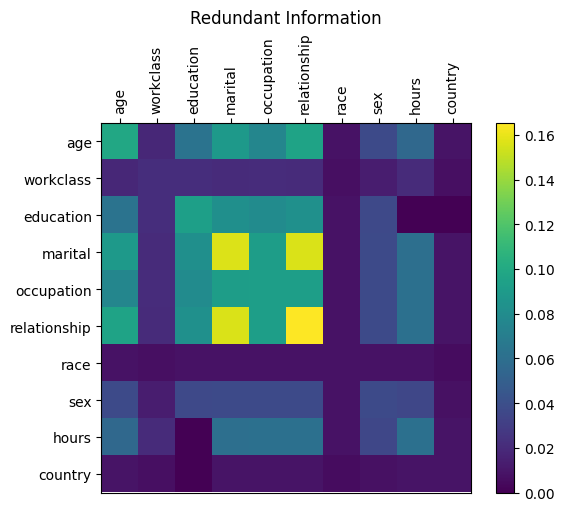

In [44]:
# Redundant Information
plt.imshow(np.clip(results[:,0],0,None).reshape(10,10))
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.xticks(np.arange(0,10,1),labels=labels, rotation='vertical', fontsize=12)
plt.yticks(np.arange(0,10,1),labels=labels, fontsize=12)
plt.colorbar()
plt.title('Redundant Information')
plt.tight_layout()
plt.savefig('redundant.png')

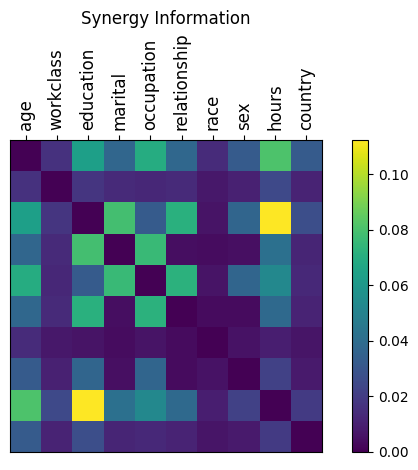

In [48]:
# Synergy Information
plt.imshow(results[:,1].reshape(10,10))
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.xticks(np.arange(0,10,1),labels=labels, rotation='vertical', fontsize=12)
plt.yticks([])
plt.colorbar()
plt.title('Synergy Information')
plt.tight_layout()
plt.savefig('synergy.png')

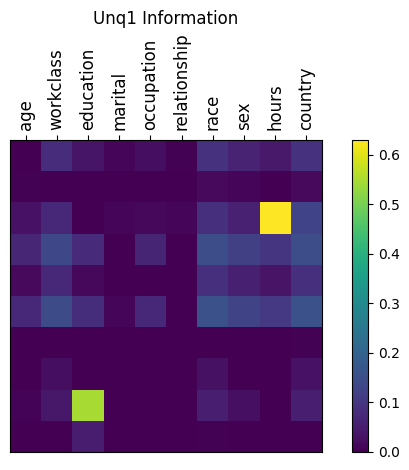

In [49]:
# Unq1 Information
plt.imshow(results[:,2].reshape(10,10))
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.xticks(np.arange(0,10,1),labels=labels, rotation='vertical', fontsize=12)
plt.yticks([])
plt.colorbar()
plt.title('Unq1 Information')
plt.tight_layout()
plt.savefig('unq1.png')

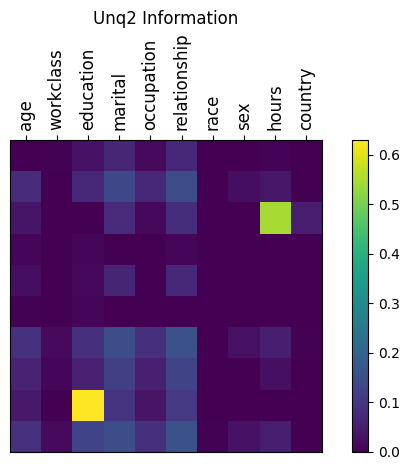

In [50]:
# Unq2 Information
plt.imshow(results[:,3].reshape(10,10))
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.xticks(np.arange(0,10,1),labels=labels, rotation='vertical', fontsize=12)
plt.yticks([])
plt.colorbar()
plt.title('Unq2 Information')
plt.tight_layout()
plt.savefig('unq2.png')

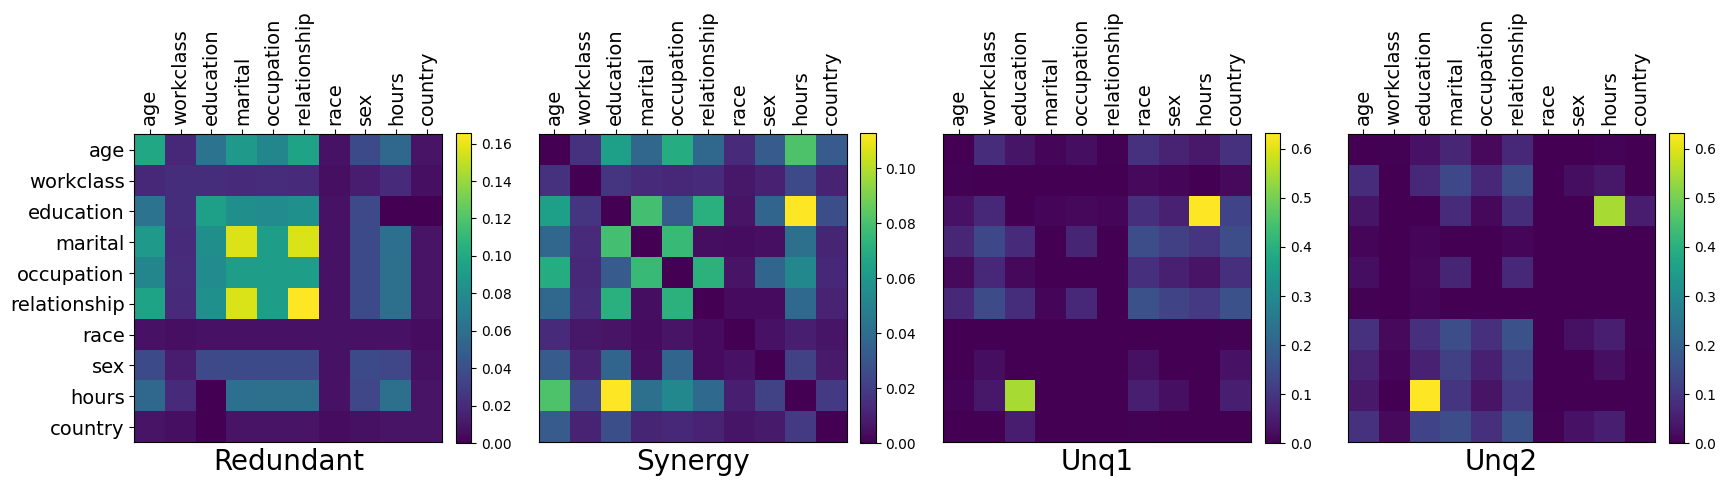

In [52]:
## Combined PID plot
fig, axs = plt.subplots(1,4,figsize=(20,40))
red=axs[0].imshow(np.clip(results[:,0],0,None).reshape(10,10))
axs[0].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
axs[0].set_xticks(np.arange(0,10,1))
axs[0].set_xticklabels(labels,rotation='vertical',fontsize=14)
axs[0].set_yticks(np.arange(0,10,1))
axs[0].set_yticklabels(labels,fontsize=14)
axs[0].set_xlabel('Redundant',fontsize=20)
fig.colorbar(red,ax=axs[0],fraction=0.046, pad=0.04)
syn=axs[1].imshow(results[:,1].reshape(10,10))
axs[1].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
axs[1].set_xticks(np.arange(0,10,1))
axs[1].set_xticklabels(labels,rotation='vertical',fontsize=14)
axs[1].set_yticks([])
axs[1].set_xlabel('Synergy',fontsize=20)
fig.colorbar(syn,ax=axs[1],fraction=0.046, pad=0.04)
unq1=axs[2].imshow(results[:,2].reshape(10,10))
axs[2].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
axs[2].set_xticks(np.arange(0,10,1))
axs[2].set_xticklabels(labels,rotation='vertical',fontsize=14)
axs[2].set_yticks([])
axs[2].set_xlabel('Unq1',fontsize=20)
fig.colorbar(unq1,ax=axs[2],fraction=0.046, pad=0.04)
unq2=axs[3].imshow(results[:,3].reshape(10,10))
axs[3].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
axs[3].set_xticks(np.arange(0,10,1))
axs[3].set_xticklabels(labels,rotation='vertical',fontsize=14)
axs[3].set_yticks([])
axs[3].set_xlabel('Unq2',fontsize=20)
fig.colorbar(unq2,ax=axs[3],fraction=0.046, pad=0.04)
plt.savefig('matrices.png')
